<h3>Basic Regression Neural Network based on data and lessons from Kaggle's <a href="https://www.kaggle.com/learn/intro-to-deep-learning"> introduction to Deep Learning course </a>. </h3>
<p>This notebook will expand upon the previous 'regression1.ipynb' notebook by exploring early stopping to correct for under- and overfitting as well as batch normalization and dropout .</p>

In [1]:
import pandas as pd
from IPython.display import display # allows the notebook to print pandas DataFrames as tables

red_wine = pd.read_csv('data/red-wine.csv')

# Create training and validation splits
df_train = red_wine.sample(frac=0.7, random_state=0)
df_valid = red_wine.drop(df_train.index)
display(df_train.head(4))

# Scale to [0, 1]
max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)
df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)

# Split features and target
X_train = df_train.drop('quality', axis=1)
X_valid = df_valid.drop('quality', axis=1)
y_train = df_train['quality']
y_valid = df_valid['quality']

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1109,10.8,0.470,0.43,2.10,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,6
1032,8.1,0.820,0.00,4.10,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,5
1002,9.1,0.290,0.33,2.05,0.063,13.0,27.0,0.99516,3.26,0.84,11.7,7
487,10.2,0.645,0.36,1.80,0.053,5.0,14.0,0.99820,3.17,0.42,10.0,6


Early stopping - we want the model to stop training once it seems the validation loss isn't continuing to decrease.

Adding in early stopping using a callback - functions that run during training

In [2]:
from tensorflow import keras
from keras import layers, callbacks

# Define early stopping callback function
early_stopping = callbacks.EarlyStopping(
    # minimum change needed to count as an imporvement
    min_delta=0.001,
    # number of epochs to wait before stopping
    patience=20,
    # keep the best weights found
    restore_best_weights=True, 
)

# Build network model - 3 layers
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[11]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])

model.compile(
    optimizer='adam',
    loss='mae',
)

<AxesSubplot:>

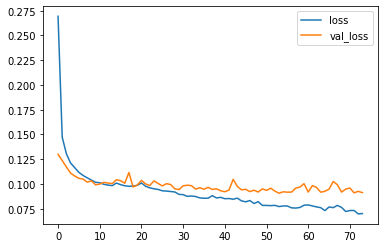

In [3]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping],
    verbose = 0 # this turns off the training log output
)

df_history = pd.DataFrame(history.history)
df_history.loc[:, ['loss', 'val_loss']].plot()

<AxesSubplot:>

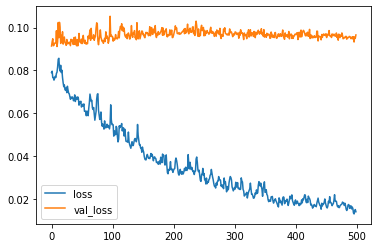

In [4]:
history_no_stop = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=500,
    # callbacks=[early_stopping],
    verbose = 0 # this turns off the training log output
)

df_history_early = pd.DataFrame(history_no_stop.history)
df_history_early.loc[:, ['loss', 'val_loss']].plot()

without early stopping, the model continues far too long and is overfitted - evidenced by increases in the validation loss.

<h3>Adding in Dropout and Batch Normalization</h3>
<p>
<h4>Dropout</h4> will randomly remove a fraction of the layer's inputs during each step of the training. This can have an effect on overfitting as it removes some specific patterns to recfous the model on broader, more robust weights.
<h4>Batch Normalization</h4> or "batchnorm" can assist in correcting slow or otherwise unstable training. A batch normalization layer will rescale its inputs by normalizing the data with its own mean and standard deviation while also placing the data on a new scale with two trainable parameters. This will aid the optimization process and occasionally improve performance of the prediction.
</p>

In [6]:
from tensorflow import keras
from keras import layers

# Deeper model than before because of adding dropout, add in dropout and batch normalization
model_dr_bn = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=[11]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1),
])

<AxesSubplot:>

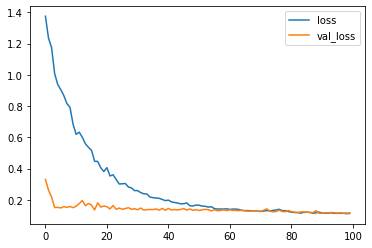

In [7]:
# compiling, fitting, and plotting will be the same

model_dr_bn.compile(
    optimizer='adam',
    loss='mae',
)

history_dr_bn = model_dr_bn.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=100,
    verbose=0,
)


# Show the learning curves
history_df_drbn = pd.DataFrame(history_dr_bn.history)
history_df_drbn.loc[:, ['loss', 'val_loss']].plot()